### Question 3: Pixel Intensity Calibration Issues – Problem Statement

In this task, a hemisphere is placed on a flat black surface and imaged using a camera directly above it, aligned with the hemisphere’s center. The camera uses an orthogonal projection and captures the top view of the hemisphere as a perfect circle. The vertical distance between the hemisphere’s top and the camera lens is fixed at **2R**, and the image is cropped so that the circular projection fits exactly within the image frame.

In folder `data/q3`, four sample scenarios are provided where pixel intensity calibration issues are visible on the factory monitor. The goal is to:

- **3-a to 3-d**: Identify the intensity-related issue in each image,
- Apply appropriate **corrections based on Section 3.2** of the textbook (e.g., bias correction, flat-field correction, shading removal),
- Compute the **mean intensity** of the corrected image,
- Compare each with the reference intensity from **Problem 2-f**,
- Finally, **discuss the calibration effect** of each correction technique.


In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [3]:
image_paths = {
    'a': '/mnt/e/Term 4/HW/DIP-HW2/data/q3/a.png',
    'b': '/mnt/e/Term 4/HW/DIP-HW2/data/q3/b.png',
    'c': '/mnt/e/Term 4/HW/DIP-HW2/data/q3/c.png',
    'd': '/mnt/e/Term 4/HW/DIP-HW2/data/q3/d.png'
}

images = {name: cv2.imread(path, cv2.IMREAD_GRAYSCALE) for name, path in image_paths.items()}

for str in 'abcd':
    print(f'Shape of image {str} is : {images[str].shape}')

Shape of image a is : (512, 512)
Shape of image b is : (512, 512)
Shape of image c is : (512, 512)
Shape of image d is : (512, 512)


In [3]:
mean_intensities = {name: np.mean(img) for name, img in images.items()}

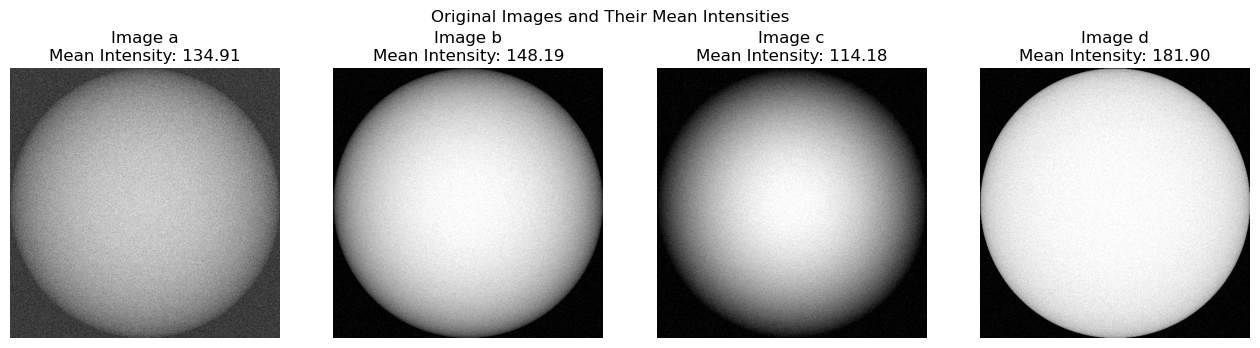

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, (name, img) in zip(axes, images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Image {name}\nMean Intensity: {mean_intensities[name]:.2f}")
    ax.axis("off")

plt.suptitle("Original Images and Their Mean Intensities")
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

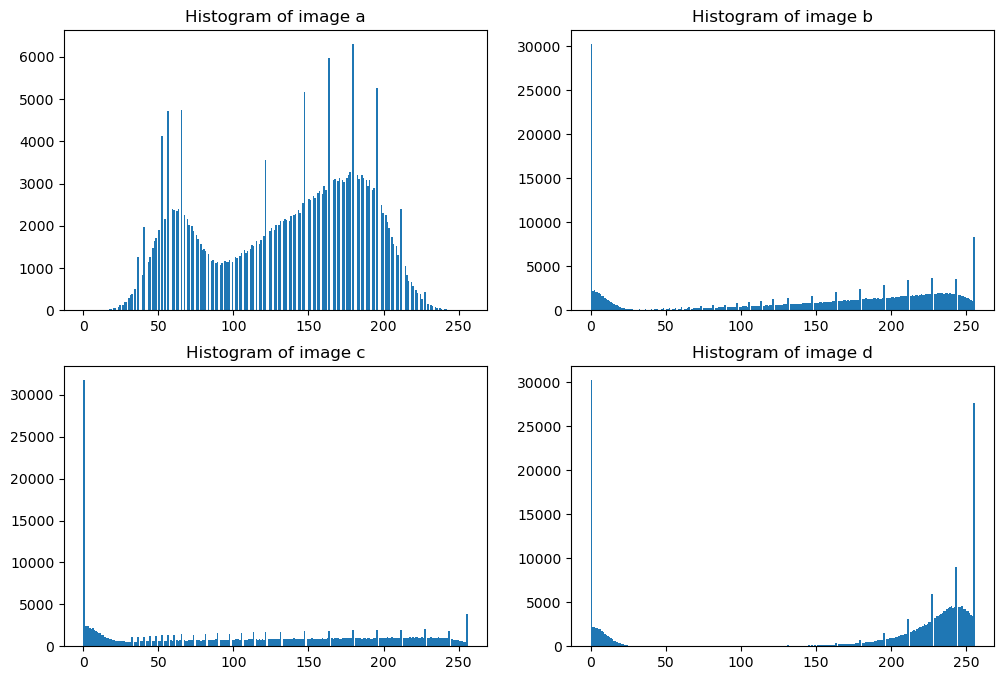

In [5]:
plt.figure(figsize=(12, 8))
for i, (name, img) in enumerate(images.items(), 1):
    plt.subplot(2, 2, i)
    plt.hist(img.ravel(), bins=256, range=[0, 256])
    plt.title(f'Histogram of image {name}')

plt.show


## To fix the problem of picture a:

In [103]:
def piecewise_linear_contrast(img, r1, s1, r2, s2):
    img = img.astype(np.float32)

    img[img <= r1] = (s1 / r1) * img[img <= r1]
    img[(r1 < img) & (img <= r2)] = ((s2 - s1)/ (r2 - r1)) * (img[(r1 <= img) & (img <= r2)] - r1) + s1
    img[img > r2] = ((255 - s2) / (255 - r2)) * (img[img > r2] - r2) + s2

    return np.clip(img, 0, 255).astype(np.uint8)

In [116]:
enhanced_img_a = piecewise_linear_contrast(images['a'], 70, 25, 205, 230)

(-0.5, 511.5, 511.5, -0.5)

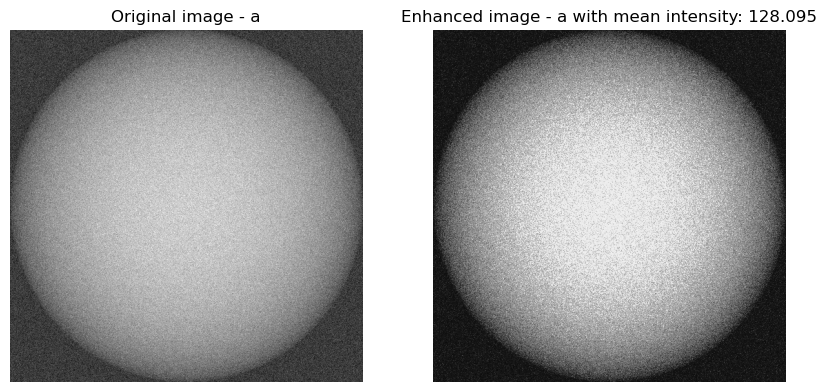

In [117]:
mean_intensity = np.mean(enhanced_img_a)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images['a'], cmap='grey')
plt.title('Original image - a')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(enhanced_img_a, cmap='grey')
plt.title(f'Enhanced image - a with mean intensity: {mean_intensity:.3f}')
plt.axis('off')

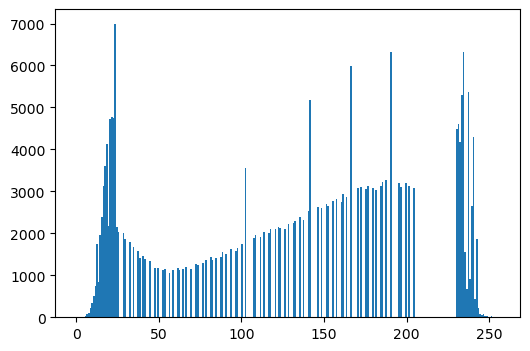

In [118]:
plt.figure(figsize=(6, 4))
plt.hist(enhanced_img_a.ravel(), bins=256, range=[0, 256])
plt.show()

## To fix the problem of picture b:

In [17]:
def replace_intensity_range(img, lower, upper, new_value):
    """
    Replace all pixel values in the range [lower, upper] with new_value.
    Pixels outside the range remain unchanged.

    Parameters:
        img (ndarray): Input grayscale image (uint8).
        lower (int): Lower bound of intensity range (inclusive).
        upper (int): Upper bound of intensity range (inclusive).
        new_value (int): Value to assign within the range.

    Returns:
        ndarray: Modified image.
    """
    output = img.copy()
    mask = (img >= lower) & (img <= upper)
    output[mask] = new_value
    return output


In [18]:
enhanced_img_b = replace_intensity_range(images['b'], 0, 15, 5)

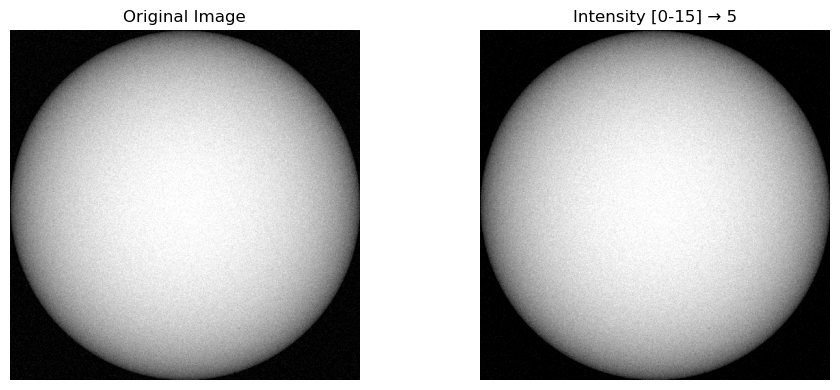

In [19]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(images['b'], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Intensity [0-15] → 5')
plt.imshow(enhanced_img_b, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

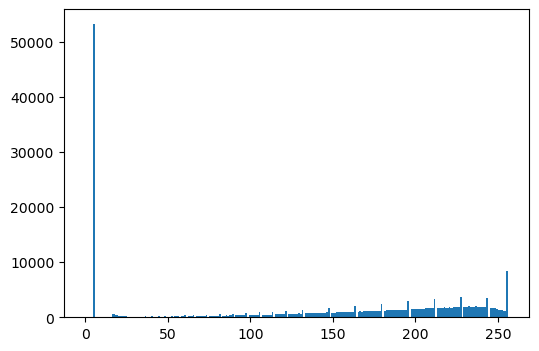

In [173]:
plt.figure(figsize=(6, 4))
plt.hist(enhanced_img_b.ravel(), bins=256, range=[0, 256])
plt.show()

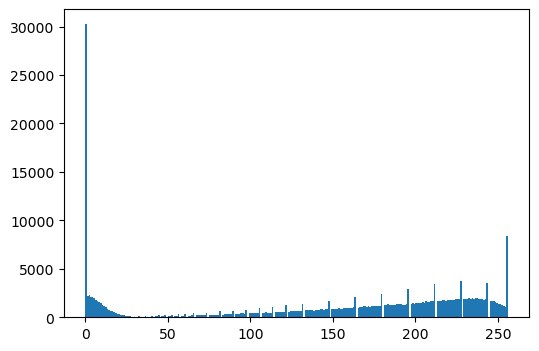

In [174]:
plt.figure(figsize=(6, 4))
plt.hist(images['b'].ravel(), bins=256, range=[0, 256])
plt.show()

In [175]:
mean_intensity_b = np.mean(enhanced_img_b)
print(f'{mean_intensity_b:.3f}')

148.630


## To fix the problem of picture c:

In [6]:
def gamma_correction(image, gamma):
    norm_image = image / 255    #0-1
    gamma_image = np.power(norm_image, gamma)

    return np.uint8(gamma_image * 255)

In [20]:
gamma = 0.67

corrected_image_c = gamma_correction(images['c'], gamma)

(-0.5, 511.5, 511.5, -0.5)

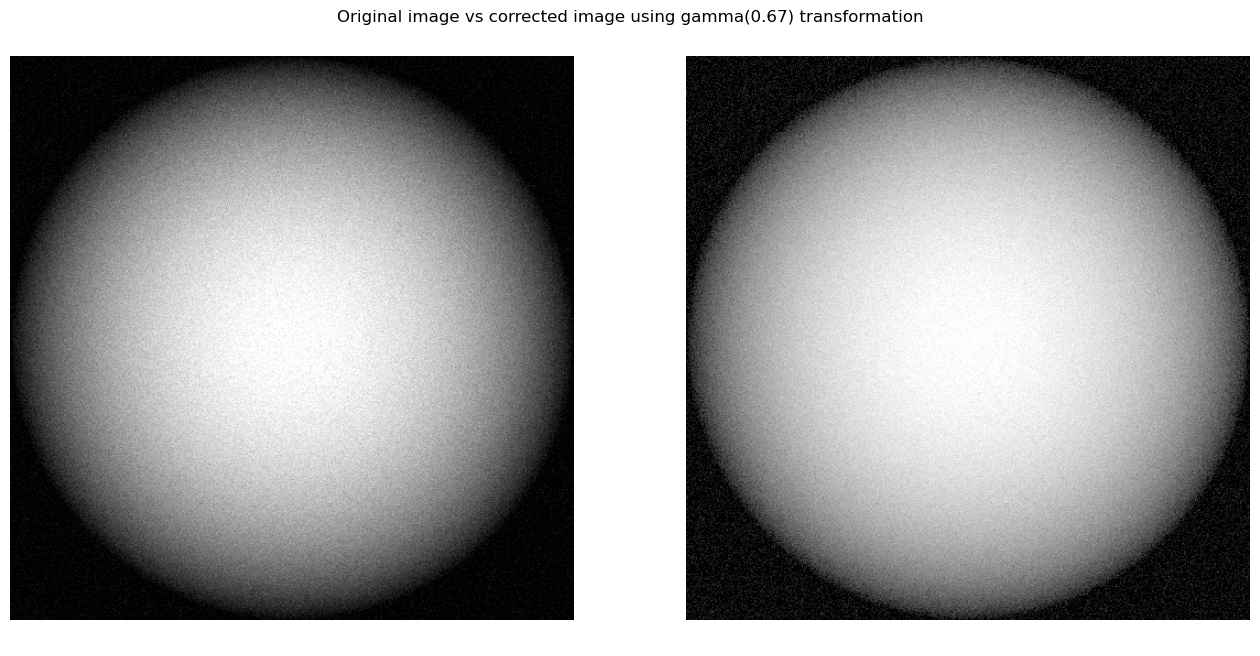

In [22]:
plt.figure(figsize=(16, 8))
plt.title(f'Original image vs corrected image using gamma({gamma}) transformation')
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(images['c'], cmap='grey')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(corrected_image_c, cmap='grey')
plt.axis('off')

In [23]:
print(np.mean(corrected_image_c))

134.15345764160156


## To fix the problem of image d:

In [4]:
def gamma_correction(image, gamma, c=1):
    norm_image = image / 255    # 0-1
    gamma_image = (np.power(norm_image, gamma)) * c

    return np.uint8(gamma_image * 255)

In [22]:
gamma = 2.51

corrected_image_d = gamma_correction(images['d'], gamma, c=0.9)

(-0.5, 511.5, 511.5, -0.5)

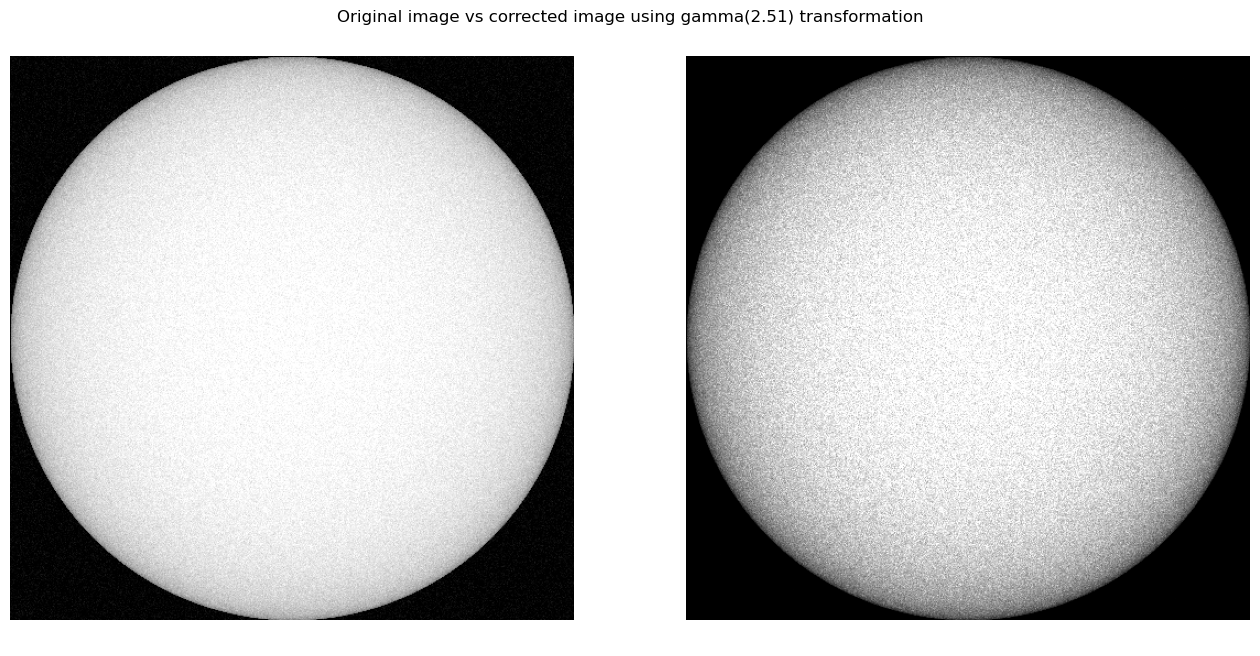

In [23]:
plt.figure(figsize=(16, 8))
plt.title(f'Original image vs corrected image using gamma({gamma}) transformation')
plt.axis('off')

plt.subplot(1, 2, 1)
plt.imshow(images['d'], cmap='grey')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(corrected_image_d, cmap='grey')
plt.axis('off')

In [7]:
print(np.mean(corrected_image_d))

148.5960807800293


In [20]:
ideal_image = enhanced_img_b
ideal_image.shape

(512, 512)

Best gamma: 2.51 with MSE: 80.51


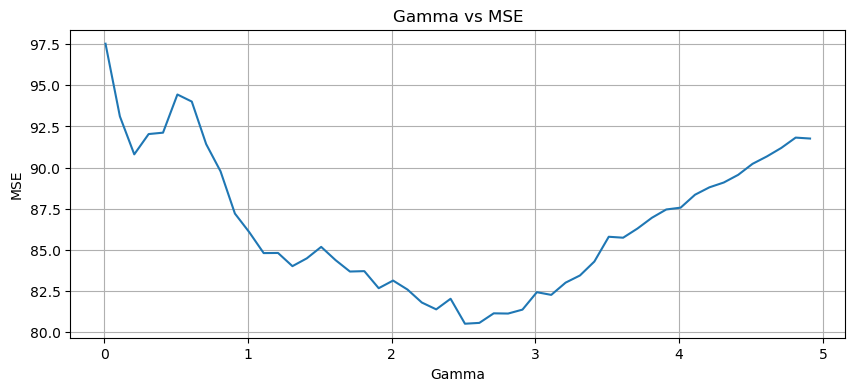

In [21]:
def find_best_gamma(image_input, image_reference, gamma_range, c=1):
    mse_values = []
    gammas = np.arange(*gamma_range)
    
    for gamma in gammas:
        corrected = gamma_correction(image_input, gamma, c)
        mse = mean_squared_error(image_reference.flatten(), corrected.flatten())
        mse_values.append(mse)
    
    best_gamma = gammas[np.argmin(mse_values)]
    print(f"Best gamma: {best_gamma:.2f} with MSE: {min(mse_values):.2f}")

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(gammas, mse_values)
    plt.xlabel("Gamma")
    plt.ylabel("MSE")
    plt.title("Gamma vs MSE")
    plt.grid(True)
    plt.show()

    return best_gamma, mse_values


best_gamma, all_mse = find_best_gamma(images['d'], ideal_image, gamma_range=(0.01, 5.01, 0.1), c=0.9)